<img src="images/reddit.jpg" height="50%" width="50%">

<h1><center>An Analysis of the Prevalence of the US Events on Reddit</center></h1>
<center><b>By Nicholus Sakha</b><center>

<hr>
<h1><center>Introduction</center></h1>
<hr>
Reddit is a social media site that is widely used internationally where users can submit content such as text posts, images, and links that can be either upvoted to show that users like the content or downvote to show that users dislike the content. There exists smaller communities called subreddits that allow users to view content and view content for specific topics such as news, politics, video games, and lifestyle. Users can interact with content in a variety of ways, such as directly commenting to posts, gifting rewards to submissions or comments, or simply by upvoting or downvoting comments.

The year 2020 has been a turbulent one for many people worldwide with events such as the Coronavirus pandemic, the U.S. election, riots, and countless other events. As a result, there are more and more submissions with links to news articles that describe these events. With many of these events occuring within the United States, many users and subreddits have grown tired of hearing solely about what is happening in the U.S. and have opted to try to filter posts that were about U.S. events or politics.

In this tutorial, our goal is to verify whether the sentiment that U.S. events have becoming more prevealent over the year 2020. We will then look past the year 2020, and look at the past 11 years to see if there are any trends with how prevalence of the US, specifically if it has grown and if posts about the US are typically more popular than those that are not. 

We will use Pushshift, a Reddit API that allows us to search Reddit comments.

Install the dependencies needed for this project

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
# In order to get make requests to get the data
import requests
import json

# To work with the data we are going to store it in a dataframe
import pandas as pd
import numpy as np
from datetime import datetime
import time

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Machine Learning and Statistics
import nltk
from nltk.tokenize import word_tokenize
# Download additional resources
nltk.download('punkt')
from collections import Counter
# For calculating IDF
import math
from heapq import nlargest
# For logisitic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h1>The Difficulties Getting Data from Reddit</h1> 

Before diving into the data collection, it is important to learn more about the choice to use pushshift for this project, and the challenges that come with querying Reddit for data.

The main difficulty that comes with getting data from Reddit is that users are unable to query Reddit for date-specific results, as we are trying to do in this project. For example, if someone was interested in all submissions from the year 2015, Reddit offers no way to specifically get those submissions. While we would be able to search using the typical Reddit timeframe filters such as last day, last month, last year, and all time, this method of querying becomes increasingly difficult as the timeframe the posts were submitted in becomes further away from present day. For example, if were to attempt to get all the 2015 posts using this method, we would have to use the 'from all time' filter and manually go through each post and determine whether they were in the specified timeframe. This involves working through an *extremely large* number of posts.

It is because of this that we turn to using PushShift to get data.

<h1>About PushShift, its Advantages and Shortcomings</h1>

As described previously, we are unable to use Reddit's exisiting API for this project since we need to get submissions within a specific timeframe. However, PushShift allows us to get around this problem.

PushShift copies submissions into their database at the time they are posted, and updates these submissions in their database with the most up to date version of comments and upvotes in regularly timed intervals. By having what is essentially a deep copy of the Reddit submissions and comments, they have built their API that allows query their database for up to 100 posts at a time, and search for variety of submission parameters, such as timeframe, score, and etc. More specifics can be learned about the PushShift API from the following links at their Reddit, Github, and Site respectively.

* https://www.reddit.com/r/pushshift/comments/bcxguf/new_to_pushshift_read_this_faq/
* https://github.com/pushshift/api
* https://pushshift.io/

However, unfortunately this is not a perfect solution to the problem. Since PushShift has to maintain their own database apart from Reddit, they do not always have the most up to date information regarding submissions from Reddit. This means that data we get back may not always be up to date. Additionally, from analysis, there are some posts that should be among the top submissions in a given year, but are completely missing when a request is sent for the top submissions, a process which will be described in the next sections. From research, it appears that these posts are missing simply because these posts have not been added to the PushShift dataset yet or have not had their upvotes updated yet, which makes sense since there is an ever increasing amount of posts that must be read into the dataset and updated as time goes on. 

While it is unfortunate, since the likelihood of a post being not included in a request for top submissions seems to be tied to the random workings of PushShift's dataset and how it updates, and not properties of the submissions like upvotes, we will label these posts as <b>Missing Completely at Random</b>. This means that when we get the top 1000 posts, we will actually be looking at a subset of the top posts in a given year. While any conclusions we draw will not be as strong as if we had the true data, having a subset of fairly accurate data still will at least be representative of the true trends of Reddit.

<hr>
<h1><center>Data Preparation</center></h1>
<hr>

<h1>Data Collection</h1> 

In order to get the data we need for this project, we need to query Pushshift in order to get the data required. Lets first make some functions. Lets make one that will get the data by querying Pushshift and get the top 100 posts from a subreddit. 

When we send a request to the PushShift API, we get a list of dictionary objects that represent a submission. The size of this list, along with what fields are included in the dictionary, are dependent on the request we send PushShift. To query pushshift, we essentially have to send a GET request to a link, which primarily involves the building of the URL. Before starting, it would be helpful to have these two links read or pulled up:

* https://github.com/pushshift/api#searching-submissions
* https://github.com/pushshift/api#search-parameters-for-submissions

To start, we are going to specify the endpoint, or base URL we will be sending the query to. In the case of submissions this will be: https://api.pushshift.io/reddit/search/submission/

To add additional parameters to search for, we will need to add an additional "?" to the end of the url followed by the parameter name, an equal sign, and finally the value of the parameter. If there are multiple parameters, there will need to be an "&" separating parameters and thier values. An example of this is shown below, with place_holder values being in "<>"

* https://api.pushshift.io/reddit/search/submission/&lt;parameter_1&gt;=&lt;value_1&gt;&amp;&lt;parameter_2&gt;=&lt;value_2&gt;

An example of searching submissions with "Trump" in the title after 2015 would be:

* https://api.pushshift.io/reddit/search/submission/title=Trump&after=2015-12-31

For the data we want, we would need to know the title, the number of upvotes, any flairs (optional text labels), what subreddit the post belongs to, and when it was created. It might also be useful to collect the link to the post and how many comments the post has. We can set this by using the "fields" parameter and setting it equal to a concatenated and comma_separated string in containing the fields below. This will prevent us from getting extranous data back from requests.

* created_utc - when the post was created
* full_link - the link to the actual post on Reddit
* num_comments - the number of comments on the post
* score - the number of upvotes the submission has
* subreddit - the name of the subreddit the submission belongs to
* title - the text title of the submission
* link_flair_text - the text of the flair assigned to the post. Flairs are essentially subcategories submissions can optionally be assigned to.

Unfortunately, it appears that there is not a comprehensive list of fields. To see what ones you want, get a request without the fields parameter and then build a string in a similar way that I do below. More information here: https://github.com/pushshift/api#using-the-fields-parameter

Additionally, we need to include the parameters before and after to get submissions from a specific timeframe. By setting the "sort_type" parameter to score, we are receiving the highest upvoted score. By including the "score=<" we can get all posts below a certain score, which will be used in the next part. Including the "size" parameter will allow us to specify how many submissions we get back, up to 100. Finally, we will need to include the "subreddit" parameter to search specific parameters.

I also included the "title" parameter for general use requesting.

The process of building the string given specific parameters is seen below, as well as an example of some output.

In [4]:
# Lets build the url which we will send requests to in order to get posts within a certain timeframe.

# For the sake of this project, we are interested in the top posts, but you can also change the 'sort_type' to 
# get posts based on the time they were created ('created_utc'), the number of comments the submission has ('num_comments'),
# or mumber of upvotes
def get_pushshift_data(term, start, end, subreddit, num_posts, score_threshold):
    # Limit the data fields we get back. We don't need everything!
    # It'd be useful to collect the flair as a potential y for machine learning predictions we do later
    f = ('created_utc,' +
         'full_link,' +
         'num_comments,' + 
         'score,' + 
         'subreddit,' +
         'title,' +
         'link_flair_text'
         )
    
    # Build the url which will send the data we are looking for
    url = ('https://api.pushshift.io/reddit/search/submission?' + 
           'title=' + str(term) +
           '&after=' + str(start) + 
           '&before=' + str(end) + 
           '&size=' + str(num_posts) + 
           '&fields=' + f +
           '&score=<' + str(score_threshold) + 
           '&sort_type=score' + 
           '&subreddit=' + str(subreddit))
    # We are ensuring we are getting the highest posts with sort
    
    # Get the data, sleep so the successive calls do not trigger a 429 response
    time.sleep(1)
    r = requests.get(url)
    
    # Convert the request into a list of dict objects
    d = json.loads(r.text)
    
    # Return a list of dictionaries for the submissions
    return d['data']

# Lets test it by getting three posts from the world news subreddit in the year 2020 that contains Trump
ex = get_pushshift_data('Trump', '2020-01-01', '2020-12-31', 'worldnews', 3, 1000000)
ex

[{'created_utc': 1578170500,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/ek25dn/on_foreign_policy_trump_flouts_risks_that_gave/',
  'link_flair_text': 'Feature Story',
  'num_comments': 5,
  'score': 0,
  'subreddit': 'worldnews',
  'title': 'On Foreign Policy, Trump Flouts Risks That Gave Others Pause'},
 {'created_utc': 1578057204,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/ejf8rl/iran_has_been_planning_a_counterstrike_on_the_us/',
  'link_flair_text': 'Trump',
  'num_comments': 16,
  'score': 0,
  'subreddit': 'worldnews',
  'title': 'Iran has been planning a counter-strike on the US for decades. Trump just lit the fuse.'},
 {'created_utc': 1578115393,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/ejsay4/rose_mcgowan_and_john_cusack_speaking_about/',
  'link_flair_text': 'Not Appropriate Subreddit',
  'num_comments': 18,
  'score': 0,
  'subreddit': 'worldnews',
  'title': 'Rose McGowan and John Cusack speaking about President Trump act

# Data Curation

Now that we pretty general method of querying PushShift RESTful API, lets now get the top 1000 posts in a year and put it in a dataframe

With there being a limit of 100 per query, if we want to get more than 100 submissions per year, we are going to have to have some workaround if we want to have more than 100 submissions per year.

One approach would be to get 100 submissions for each of the 12 months, and then aggregate over them. However, this method would limit the type of exploratory analysis we could do. For example, if we wanted to see the distribution of month vs. upvotes, we would not see the whole picture since the true distribution of the most popular posts may only be in a few select months, rather than all.

What we are going to do instead is sample the whole year but each time keep track of the score. After each query, we will search for all posts below the lowest score from the last batch that was returned. This is why we included the "score=<" field in our function.

At the end of this iterative process, we will have a list of 1000 dictionary objects that can trivially transformed into a Pandas DataFrame. An example of this is output at the bottom of the next code cell, for getting the top 1000 posts of the worldnews Reddit for the year 2020.

In [5]:
# num_top is expected to be a multiple of 100
def get_top_submissions_for_year(subreddit, term, year, num_top):
    return_lst = []
    num_iter = num_top//100
    # Preset the max score to 1 million and lower it based on the lowest submission score
    max_score = 1000000
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    
    for i in range(num_iter):
        return_lst = return_lst + get_pushshift_data(term, start_date, end_date, subreddit, 100, max_score)
        max_score = return_lst[-1]['score']
        
    return pd.DataFrame(return_lst)

# Example of getting the top 1000 entries from worldnews
df = get_top_submissions_for_year('worldnews', '', 2020, 1000)
df

,created_utc,full_link,num_comments,score,subreddit,title,link_flair_text
0,1578072754,https://www.reddit.com/r/worldnews/comments/ej...,1,0,worldnews,Only one person died on Oslo’s roads during th...,NaN
1,1578071433,https://www.reddit.com/r/worldnews/comments/ej...,6,0,worldnews,Dozens of Iranian ships surrounded the US airc...,Daily Mail story on 12/31
2,1578048003,https://www.reddit.com/r/worldnews/comments/ej...,4,0,worldnews,Cosmetics maker Avon Products CEO steps down,NaN
3,1578074226,https://www.reddit.com/r/worldnews/comments/ej...,5,0,worldnews,Franz Ferdinand and #WWIII: Why are these word...,Opinion/Analysis
4,1578134022,https://www.reddit.com/r/worldnews/comments/ej...,0,0,worldnews,'It was coming towards us like a monster',No Images/Videos
...,...,...,...,...,...,...,...
95,1583346204,https://www.reddit.com/r/worldnews/comments/fd...,2,0,worldnews,Iran's Answer to the Coronavirus Outbreak: Cut...,NaN
96,1583360806,https://www.reddit.com/r/worldnews/comments/fd...,2,0,worldnews,'The Simpsons' Predict Coronavirus Outbreak!,NaN
97,1583362506,https://www.reddit.com/r/worldnews/comments/fd...,14,0,worldnews,John Roberts Condemns Schumer for Saying Justi...,Behind Soft Paywall
98,1583686661,https://www.reddit.com/r/worldnews/comments/ff...,0,0,worldnews,Portugal's president suspends his schedule for...,NaN


<h1>Data Tidying</h1>

Now lets make the DataFrame more tidy, as its current layout is a bit unituitive. 

Lets swap the order of columns around and replace the created_utc column with a datetime object to improve what we can get from looking at the table. Having a datetime object in the column is also much easier for plotting, which we will do in the Exploratory Data Analysis section. 

While the full_link is useful for troubleshooting and confirming, it probably also will not be too useful in our analysis. 

Finally, lets rename the column titles to be a bit more descriptive.

In [6]:
def tidy_df(df):
    df = df.copy()
    date_time_lst = [datetime.utcfromtimestamp(x) for x in df['created_utc']]
    df['date'] = date_time_lst
    df = df.drop(['created_utc', 'full_link'], axis=1)
    if 'link_flair_text' not in df.columns:
        df['link_flair_text'] = np.nan
    df = df[['title','score','date','link_flair_text','num_comments','subreddit']]
    df = df.rename(columns={'title':'submission_name','link_flair_text':'flair'})

    return df

# Example tidying the df we got from the last step
d = tidy_df(df)
d

,submission_name,score,date,flair,num_comments,subreddit
0,Only one person died on Oslo’s roads during th...,0,2020-01-03 17:32:34,NaN,1,worldnews
1,Dozens of Iranian ships surrounded the US airc...,0,2020-01-03 17:10:33,Daily Mail story on 12/31,6,worldnews
2,Cosmetics maker Avon Products CEO steps down,0,2020-01-03 10:40:03,NaN,4,worldnews
3,Franz Ferdinand and #WWIII: Why are these word...,0,2020-01-03 17:57:06,Opinion/Analysis,5,worldnews
4,'It was coming towards us like a monster',0,2020-01-04 10:33:42,No Images/Videos,0,worldnews
...,...,...,...,...,...,...
95,Iran's Answer to the Coronavirus Outbreak: Cut...,0,2020-03-04 18:23:24,NaN,2,worldnews
96,'The Simpsons' Predict Coronavirus Outbreak!,0,2020-03-04 22:26:46,NaN,2,worldnews
97,John Roberts Condemns Schumer for Saying Justi...,0,2020-03-04 22:55:06,Behind Soft Paywall,14,worldnews
98,Portugal's president suspends his schedule for...,0,2020-03-08 16:57:41,NaN,0,worldnews


<h1>Getting all the Data</h1>

Now that we have all these functions in place, lets get all the data that we will need.

We will define a function that will combine the functions from all the previous steps and return a single DataFrame ready for work. Essentially, we just need to call tidy_df() on the dataframe we get back from get_top_submissions_for_year(). The parameters needed for this are the subreddit we are interested in searching (subreddit), the term in the title (term), if any, the year we are interested in (year) , and finally the number of top posts we want (num_top), which must be a multiple of 100.

Since we have to include a wait so that we do not get a 429 Response (Too Many Requests), it would be much easier, especially in the future to write all this data to a csv so we can read it later. Pandas has a method for doing this given a DataFrame, making this step extremely easy. 

The only other thing we are going to do, is just repeat the above function for 11 different years, and store the resulting DataFrame in a .csv in our working directory. Lets call this function get_data_10_years(), taking the string name of a subreddit as a parameter.

Finally, lets only call this function if necessary, as the waiting to avoid a 429 error is extensive!

In [7]:
def get_data(subreddit, term, year, num_top):
    return tidy_df(get_top_submissions_for_year(subreddit, term, year, num_top))

# Function to get all world news data
def get_data_10_years(subreddit):
    year_lst = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
    return_lst = []
    for year in year_lst:
        df = get_data(subreddit, '', year, 1000)
        return_lst.append(df)
        df.to_csv(subreddit + '_' + str(year) + '.csv', index = False, header = True)
    return return_lst
       
# Keep a boolean value to determine if we need to re-collect data
fresh_run = False

if (fresh_run):
    worldnews_lst = get_data_10_years('worldnews')

<hr>
<h1><center>Exploratory Data Analysis</center></h1>
<hr>

Now that we have the data, we can do some exploratory data analysis. For the of reproducability, I have stored the dataframes that I will using in my analysis in this zip so that they can be downloaded if anything were to happen to either the Reddit API or the PushShift API. 

<a href="data.zip">Click here to download the data in a .zip file.</a>

Unfortunately, we will have to reconvert the date column into a datetime object when we read it from a csv. Luckily, Pandas has a function that will do this for us without much work because of the format the datetime object was saved as in the csv.

To start, lets load the .csv files we created in the last part into variables we will perform analysis on.

In [8]:
def convert_str_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

# My csv files are in a directory called data
worldnews_2020 = convert_str_datetime(pd.read_csv('data/worldnews_2020.csv'))
worldnews_2019 = convert_str_datetime(pd.read_csv('data/worldnews_2019.csv'))
worldnews_2018 = convert_str_datetime(pd.read_csv('data/worldnews_2018.csv'))
worldnews_2017 = convert_str_datetime(pd.read_csv('data/worldnews_2017.csv'))
worldnews_2016 = convert_str_datetime(pd.read_csv('data/worldnews_2016.csv'))
worldnews_2015 = convert_str_datetime(pd.read_csv('data/worldnews_2015.csv'))
worldnews_2014 = convert_str_datetime(pd.read_csv('data/worldnews_2014.csv'))
worldnews_2013 = convert_str_datetime(pd.read_csv('data/worldnews_2013.csv'))
worldnews_2012 = convert_str_datetime(pd.read_csv('data/worldnews_2012.csv'))
worldnews_2011 = convert_str_datetime(pd.read_csv('data/worldnews_2011.csv'))
worldnews_2010 = convert_str_datetime(pd.read_csv('data/worldnews_2010.csv'))

df_lst = [worldnews_2010, worldnews_2011, worldnews_2012, worldnews_2013, worldnews_2014, worldnews_2015, worldnews_2016, 
          worldnews_2017, worldnews_2018, worldnews_2019, worldnews_2020]

To begin, lets look at the distribution of upvotes vs. time for the year 2020. There were two notable events in the US that garnered a lot of international attention, those being:

1) Initial COVID outbreaks in the US in March/April

2) BLM Protests that occurred after the death of George Floyd in the Summer of 2020

By visualizing this distribution, we will be able to see if the US does get more popular posts during these months, and if so then this might be a good indicator for whether the US was more prevalent in news during the year 2020. The US had many different issues come up that in the past year, and if there is a considerable amount of traffic with two events, then there might be even more in total.

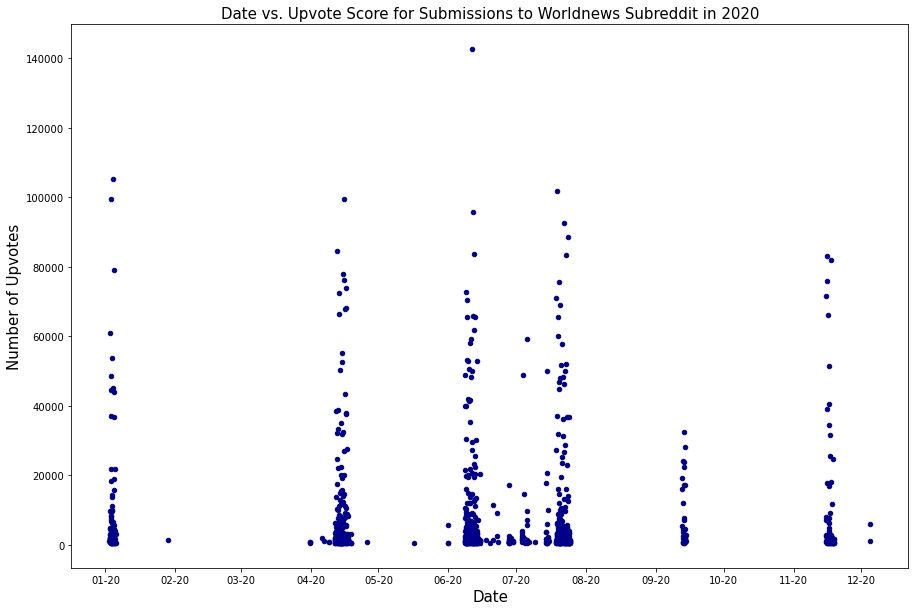

In [9]:
plot = worldnews_2020.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

Looking at the scatter plot above, it would appear that our predicition may at least be partially true. Lets investigate this further by looking making simple classifiers for the title to see whether they fit in our category.

To do this, lets just make a list of terms that may be in the title of a post about that topic. If any term is within that title, we would keep it and display its score on the scatterplot.

For the first event on the Coronavirus, some terms that might be a good indicator that the submission is about would just be if it contained the different variations that the modern Coronavirus has been referred to, such as:
* covid
* covid-19
* corona
* coronavirus

We can use the (?i) marker when defining our term list since there may be many cases of different captialization. Since the words do not mean drastically different things depending on capitalization, we should ignore. However, we should not do the same thing in the case of "us" and "US"

Additionally, we can use flairs to determine the content. The worldnews subreddit has used the "COVID-19" flair to denote submissions as related to COVID, and we can use this to also determine whether a submission is about the coronavirus.

Submissions that match:
253


,submission_name,score,date
7,"Research finds that New Zealand beat Covid-19 by trusting leaders and following advice. Citizens had a high level of knowledge about coronavirus and how it spread, and compliance with basic hygiene practices and trust in authorities was at nearly 100%.",88642,2020-07-23 20:50:32
15,"We Alerted The World' To Coronavirus On Jan. 5, WHO Says In Response To U.S.",76343,2020-04-15 20:18:40
16,Anti-vaxxers ‘could be banned from going into work if they refuse Covid jab’,75812,2020-11-15 16:47:00
18,"Brazilian President Bolsonaro Fires Health Minister Who Refused To Downplay Pandemic | “Brazil is the only country in the world where the Minister of Health will fall for having decided to fight the Coronavirus,” a leftist politician said.",73910,2020-04-16 19:38:23
20,"Coronavirus 10 times more deadly than swine flu, says WHO",72593,2020-04-13 17:13:37
21,Germany hails couch potatoes as heroes of coronavirus pandemic,71640,2020-11-15 13:22:59
27,Iceland finds that half its citizens with coronavirus have shown no symptoms: The island nation has tested more of its population for COVID-19 than any other country,66472,2020-04-13 10:37:40
31,Israeli doctor reinfected with coronavirus 3 months after recovering,65434,2020-07-19 15:06:05
40,COVID-19: Brazilian trial for drug touted by Trump halted after 11 patients die on high dose,55294,2020-04-14 21:58:43
45,Trump to halt WHO funding amid review,52720,2020-04-14 22:26:29


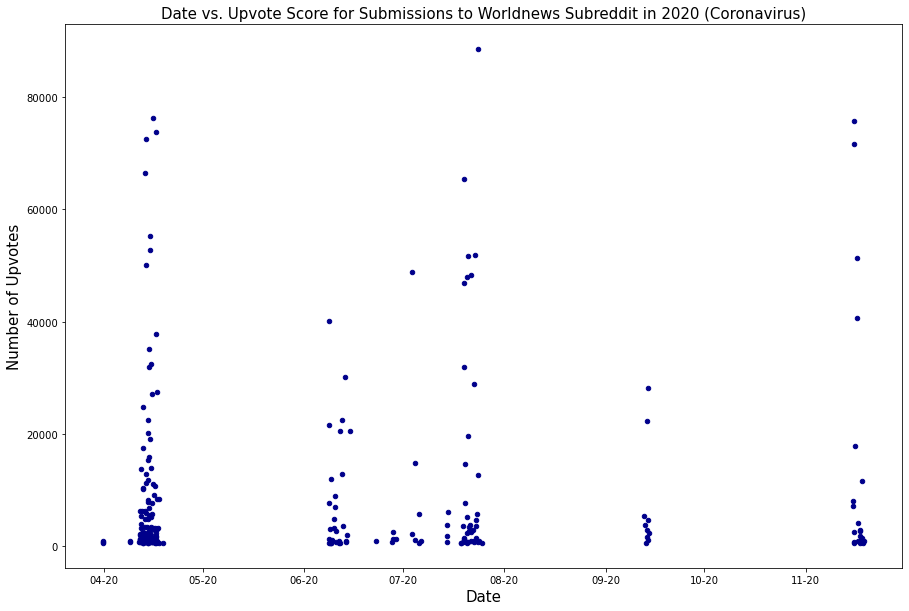

In [10]:
terms = '(?i)covid|covid-19|corona|coronavirus'
lst_1 = worldnews_2020['submission_name'].str.contains(terms).tolist()
lst_2 = (worldnews_2020['flair'] == 'COVID-19').tolist()
filter_lst = []
for i in range(len(lst_1)):
    filter_lst.append(lst_1[i] or lst_2[i])
filter_lst = pd.Series(filter_lst)
covid_df = worldnews_2020[filter_lst]
print('Submissions that match:')
print(len(covid_df))
plot = covid_df.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020 (Coronavirus)', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

temp = covid_df.copy()
with pd.option_context('display.max_colwidth', None):
  display(temp.drop(['flair','num_comments','subreddit'], axis=1).head(15))

With the scatter plot above, it seems that out prediction of a surge of posts about the Coronavirus when it hit the US in Spring may be true! To look further, lets make another 'classifier' to filter out posts further to see what proportion of these posts about Coronavirus may also be related to the US.

For the terms that may indicate whether or not whether a post is about the US, lets use (case specific):
* US
* United States
* U.S.

Submissions that match:
27


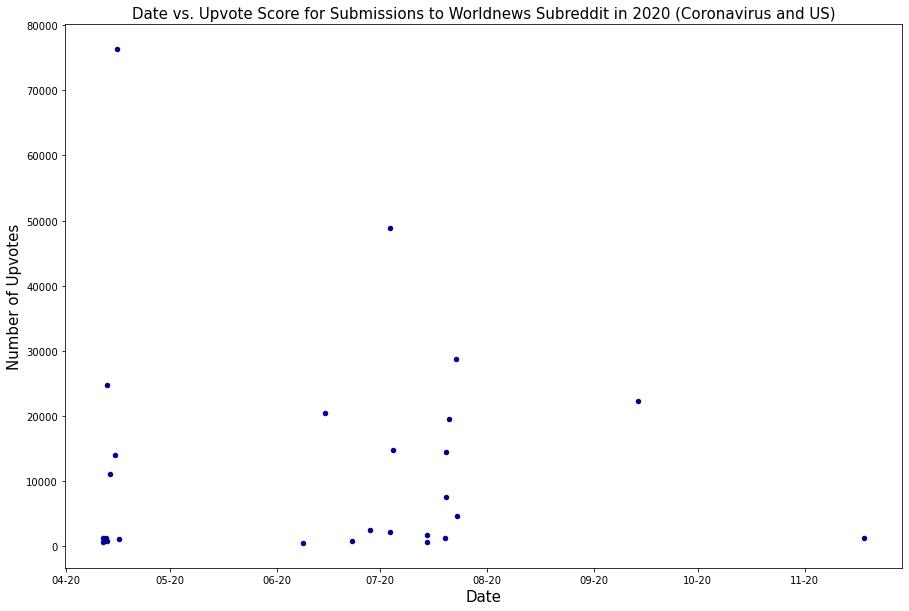

In [11]:
us_terms = 'US|United States|U.S.'
filter_lst = covid_df['submission_name'].str.contains(us_terms).tolist()
covid_us_df = covid_df[filter_lst]
print('Submissions that match:')
print(len(covid_us_df))
plot = covid_us_df.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020 (Coronavirus and US)', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

By filtering the submissions further, we see that top submissions about the Coronavirus and the US are either centered around April, or spread out in the summer. It's worth noting that of the original 253 coronavirus submissions in the year, 27 seem to about about the US.

Lets take one further look at how many fall within April and how many do not, in addition to looking at the top few posts.

In [12]:
temp = covid_us_df.copy()
with pd.option_context('display.max_colwidth', None):
  display(temp.drop(['flair','num_comments','subreddit'], axis=1).head(15))

# Now lets see how many of these 27 posts were in April
count = 0
may_datetime = datetime.strptime('2020-05-01', '%Y-%m-%d')
for d in temp['date'].to_list():
    if d < may_datetime:
        count = count + 1
        
print('Total submissions in April: ' + str(count))

,submission_name,score,date
15,"We Alerted The World' To Coronavirus On Jan. 5, WHO Says In Response To U.S.",76343,2020-04-15 20:18:40
55,"Mexico closes US border in Arizona to stop July 4th visitors, citing COVID-19 fears",48789,2020-07-03 20:58:04
98,Bill Gates denies conspiracy theories that say he wants to use coronavirus vaccines to implant tracking devices - 28% of U.S. adults believed a debunked conspiracy theory suggesting Gates planned to use a vaccine to implant microchips in billions of people to monitor their movements,28827,2020-07-22 20:22:13
109,"Caribbean nations can’t get U.S. masks, ventilators for COVID-19 under Trump policy",24721,2020-04-12 17:35:35
117,A 26 year old US woman has acted as super spreader for one of Germany's currently largest outbreak of Covid-19 when she visited multiple clubs and bars in one evening despite showing coronavirus-like symptoms.,22326,2020-09-13 14:11:02
127,Israel deports US billionaire's son for breaking virus rules,20431,2020-06-14 21:19:39
133,‘I’m not willing to go’: Canadian truckers worry about entering U.S. due to coronavirus,19558,2020-07-20 23:02:59
156,"Nigel Farage has been reported to UK police after apparently visiting a pub less than a fortnight after a trip to a Donald Trump rally in the United States. Anyone returning from overseas is required supposed to self-isolate for 14 days under current quarantine laws, with few exceptions.",14735,2020-07-04 17:25:35
158,American Tourists Banned in Bahamas After Latest U.S. Coronavirus Numbers,14536,2020-07-20 02:13:31
162,"The Pentagon’s top general has said that US intelligence has looked into the possibility that the coronavirus outbreak could have started in a Chinese laboratory, but that the “weight of evidence” so far pointed towards “natural” origins.",13962,2020-04-15 04:59:16


Total submissions in April: 10


Looking at this, there are about 10 submissions clustered together in April, and the remaining 17 were spread over the remainder of the year.

Currently, these statistics are not too telling of a US prevalence on the worldnews subreddit. Only about 10% of all top submissions about the Coronavirus are about the US. Lets keep looking with the Black Lives Matter Protests in the summer of 2020.

However, it is important to note that these results make sense for the most part! Even though our classifier was not able to get a large proportion of submissions to be about the US and the Coronavirus, these the times that were centers of the distribution seem to align with surges in the Coronavirus. As we see centers mid April and mid July, we also see a surge in daily cases. See the image below, courtesy of BBC.(https://www.bbc.com/news/world-us-canada-54670386)

<img src="images/c19-bbc.png">

Lets repeat the process that we did when searching for submissions about the Coronavirus and create a list of terms to search for submissions relevant to the Black Lives Matter protests. Some terms that might be a good hit are (non-case sensitive):

* BLM
* riot
* protest
* floyd
* Black Lives Matter
* defund
* rioters

Theses terms were chosen because the were some of the most popular words used to describe the protests that went on at the time. I also included 'defund' because of the popular saying of "defund the police" that was going on during this time.

Let's also see the top 5 submission's titles, to get a gauge on whether the most popular posts are specific to the US, or just protests in general

Submissions that match:
54


,submission_name,score,date
0,"Scottish Parliament votes for immediate suspension of tear gas, rubber bullet and riot shield exports to US",142729,2020-06-11 12:15:34
2,Thousands rally in Russia for 8th straight day of anti-Putin protests,101881,2020-07-19 00:04:04
23,US protests: British photographer arrested and charged for “unlawful assembly” - Adam Gray said he had been taking photos of demonstrators near Union Square in New York City on Saturday evening when he was thrown to the ground by one police officer before several other officers climbed on top of him,70429,2020-06-09 09:02:35
42,Russia urges the U.S. to ‘observe democratic standards’ and respect Americans’ right to protest,53109,2020-06-09 02:50:18
49,"Two Canadian Police Officers Have Been Charged After Killing Potential Witness: Two Alberta RCMP officers killed Clayton Crawford at a truck stop in 2018. Now, amid protests across the world over police brutality, the pair have been charged.",50629,2020-06-10 04:29:15
54,Bollywood Actors Called Out For Supporting Black Lives Matter Movement While Promoting Skin Lightening Products,48995,2020-06-08 13:10:19
62,"Protesters break into PM Scott Morrison’s home and vow to ‘s*** in his pool’ over wildfire outrage | ""The police say 'the accused does not appear to feel any remorse for his crimes, and in fact appears to be quite proud of his actions'. And never, never, have the police so accurately described me.""",45079,2020-01-04 03:51:35
97,Nigel Farage loses LBC radio show 'with immediate effect' after comparing Black Lives Matter protesters to the Taliban,29657,2020-06-11 15:14:02
101,Indigenous groups in Australia overwhelmed with support due to Black Lives Matter rallies,27395,2020-06-11 07:18:33
108,"""'They pointed their guns at us and started shooting"" - CNN investigation reveals how the Nigerian Army opened fire on peaceful #EndSARS protesters protesting against police brutality on October 20, 2020.",24738,2020-11-18 11:38:02


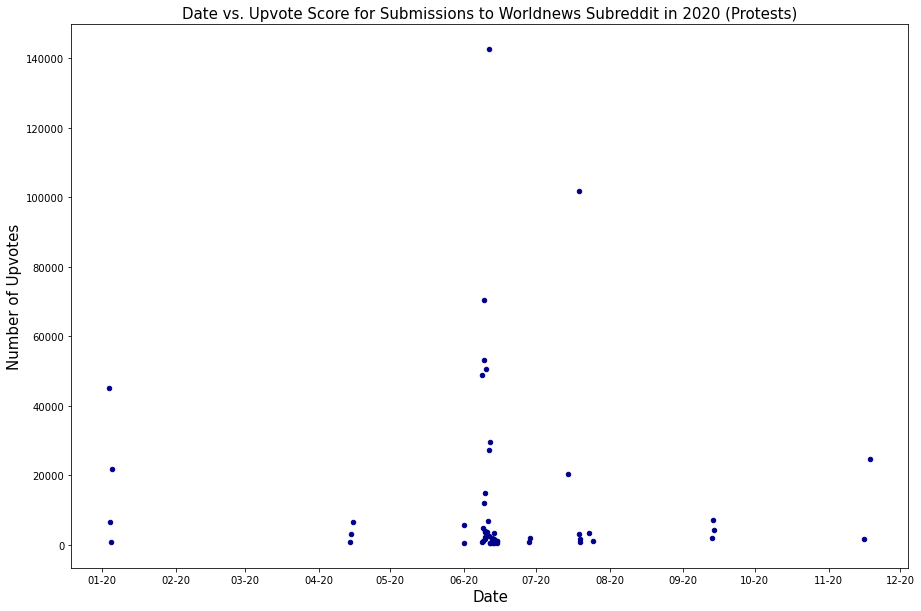

In [13]:
terms = '(?i)blm|riot|protest|floyd|black lives matter|defund|rioters'
protest_df = worldnews_2020[worldnews_2020['submission_name'].str.contains(terms)]
print('Submissions that match:')
print(len(protest_df))
plot = protest_df.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020 (Protests)', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))


temp = protest_df.copy()
with pd.option_context('display.max_colwidth', None):
  display(temp.drop(['flair','num_comments','subreddit'], axis=1).head(15))

Looking at the scatterplot, it appears that there is a center for protests around the predicted timeframe of the summer of 2020! We see in total, there are 54 submissions that match! Additionally, looking at the top 5 submissions it would seem almost all are about the US. It's important to note that during this time, the protests in the US also sparked protests worldwide. This is seen in the final submission printed above, where the story two Canadian police seems to have been influenced by events in the US. This is important to note, as events in the US may have influenced events in other countries, making it hard to determine exactly how much the US is prevalent in news if they are not explicitly mentioned in the title.

Let's try to use a similar technique with the US classifier and see if we can see a center in mid June by filtering the protest submissions further.

Let's currently just reuse the same term list as before, which was just different case sensitive variations of the "United States"

Submissions that match:
10


,submission_name,score,date
0,"Scottish Parliament votes for immediate suspension of tear gas, rubber bullet and riot shield exports to US",142729,2020-06-11 12:15:34
23,US protests: British photographer arrested and charged for “unlawful assembly” - Adam Gray said he had been taking photos of demonstrators near Union Square in New York City on Saturday evening when he was thrown to the ground by one police officer before several other officers climbed on top of him,70429,2020-06-09 09:02:35
42,Russia urges the U.S. to ‘observe democratic standards’ and respect Americans’ right to protest,53109,2020-06-09 02:50:18
121,"Thousands Take to Streets in More Than 70 Cities Across US to Protest Trump's | ""Reckless Acts of War"" Against Iran ""The American people have had enough with U.S. wars and are rising up to demand peace with Iran.""",21847,2020-01-05 01:38:49
124,"The British ambassador to the US has launched an official complaint over the arrest of an Independent journalist covering protests in Seattle - Journalist Andrew Buncombe was shackled, assaulted and detained for more than six hours after being accused of “failing to disperse” in Seattle.",20525,2020-07-14 12:43:09
345,Boris Johnson says US 'bastion of peace and freedom' amid mass protests against police brutality,3557,2020-06-10 12:41:41
482,"The deaths of a father and son from alleged torture at the hands of police have sparked outrage across India, with many drawing parallels with the killing of George Floyd in the United States. Their case has thrown a new spotlight on police brutality in India just weeks after the killing of Floyd",1982,2020-06-28 16:44:27
530,"From Minneapolis to Madrid, racial profiling and police harassment cost lives: The death of George Floyd in the United States has resonated in Spain, where black people are seven times as likely to be stopped by police as white people.",1717,2020-06-13 16:07:54
639,"‘They set us up’: US police arrested over 10,000 protesters, many non-violent",1134,2020-06-09 02:22:23
678,"China, Russia And Iran Mock U.S. Handling Of Protests: ‘I Have A Dream, But I Can’t Breathe’",1016,2020-06-14 19:07:43


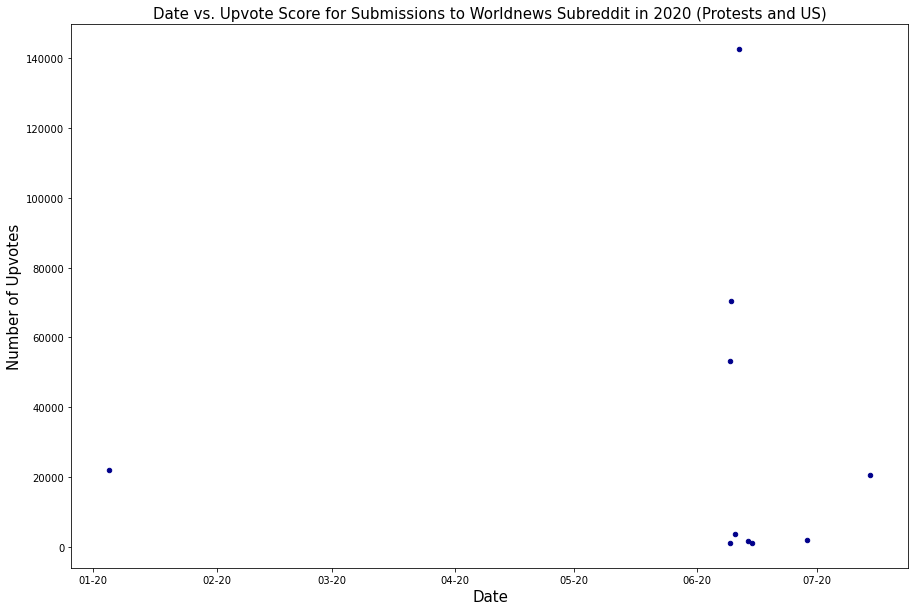

In [14]:
us_terms = 'US|United States|U.S.'
filter_lst = protest_df['submission_name'].str.contains(us_terms).tolist()
protest_us_df = protest_df[filter_lst]
print('Submissions that match:')
print(len(protest_us_df))
plot = protest_us_df.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020 (Protests and US)', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

temp = protest_us_df.copy()
with pd.option_context('display.max_colwidth', None):
  display(temp.drop(['flair','num_comments','subreddit'], axis=1).head(15))

Once again we see that the US is explicitly mentioned in 20% of submissions about protests. However, it could be argued that about 90% of these articles had the US involved at least indirectly, as many protests broke out in countries such as France in response to the events that were occuring in the US. Finally, it is a bit unfair to limit to further limit the scope to titles that include both sets of terms since terms like "Black Lives Matter" already have origins and ties to the US.

If we were to count the 27 submissions that were about the US and Coronavirus and about 90% of the 54 submissions about rioting (Since it is arguable that most posts about protests had ties to the US protests), then about 75 out of the top 1000 posts, then the US took up 7.5% of the most popular submissions with just two main events that occurred in 2020.

If only two events led the US to take up almost 10% of the top submissions, then it is very likely that including all the events will lead the US to have an even higher percentage of the top posts for the year 2020. In the next section, we will attempt to predict this amount by refining our US classifer to see how much the US was involved in the top 1000 submissions of 2020, and using machine learning techniques, specifically linear regression, to predict whether this percentage per year has been increasing over the past 11 years. 

<hr>
<h1><center>Classification and Prediction</center></h1>
<hr>

To begin, we are going to refine our basic US classifier. Intuitively, there are more terms other than US, U.S. and United States that signify whether a submission pertains to the US. A trivial example is "Trump", the current president of the United States. 

To do this, we will fit a logisitic regression to the titles of the top 100 submissions of 2020 and use it to see if there are any more terms that we should add to our naive US classifier. This will involve converting the titles of submissions to a bag of words representation, where each submission title is a vector of word frequencies. These will be our X's, or input data that we will use to predict the y, or expected result. After fitting the model, we will get the logisitic model's highest coefficients as a gauge for the most impactful words for classifying submissions about the US.

To do this, we are using the Natural Language Toolkit in Python to tokenize words. A trivial example is displayed below.

In [15]:
s = "This is a test setence! It will include the 320 in CMSC 320!"

words = nltk.word_tokenize(s)

new_list = list()
words = [new_list.append(word.lower()) for word in words if word.isalnum()]

print(new_list)

['this', 'is', 'a', 'test', 'setence', 'it', 'will', 'include', 'the', '320', 'in', 'cmsc', '320']


First lets make a dictionary that keep tracks of the frequency of each word in every submission title for the top 100 submissions of 2020. We will do this by first iterating over every title, and then iterating over every alphanumeric word in the title, and either adding it to our dictionary or incrementing its value in our dictionary.

Lets also display the top 10 most commonly used words using the Counter module in Python, which can take a dictionary as a paramter and return the n highest values using the most_common() function.

In [16]:
# Get the submissions using our 'naive' US classifier
data = worldnews_2020.head(100)

# Create a dictionary to keep track of the frequency
freq = dict()
titles = data['submission_name'].to_list()

for title in titles:
    for word in nltk.word_tokenize(title):
        if word.isalnum():
            if word in freq.keys():
                freq[word] = freq[word] + 1
            else: 
                freq[word] = 1

# Display the results
c = Counter(freq)
c.most_common(10)

[('to', 66),
 ('of', 53),
 ('the', 52),
 ('in', 44),
 ('for', 32),
 ('a', 27),
 ('and', 25),
 ('on', 17),
 ('coronavirus', 15),
 ('with', 13)]

As expected, articles dominate the most frequently used words. To circumvent this issue and gain insight into the potential words to add, we are going to calculate the TF-IDF, which is a combination of the <b>term frequency</b> and <b>inverse document frequency</b>. Essentially, we are going to punish terms that appear too frequently, such as articles, so that we can see which terms are more significant. To read more into this, read here: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

To do this, we first have to calculate the IDF, which means we will have to represent each title as a bag of words, where each title will be represented as a vector of word frequencies. This is simple, as we already have the list of all words from our dataset as keys in our dictionary, 'freq'. Now we just have to iterate through each submission name and build a bag of words for each.

In [17]:
df = pd.DataFrame(columns = freq.keys())
valid_words = freq.keys()

# Create a index dictionary so we can quickly find which element corresponds to each word
ind_dict = dict()
for i,word in enumerate(freq.keys()):
    ind_dict[word] = i

for title in titles:
    # Create a list of size that matches how many terms we have. Init each to 0
    row = [0] * len(freq.keys())
    # If a word is found, increment its frequency
    for word in nltk.word_tokenize(title):
        if word.isalnum():
            row[ind_dict[word]] = row[ind_dict[word]] + 1
    df.loc[len(df)] = row

df

,Scottish,Parliament,votes,for,immediate,suspension,of,tear,gas,rubber,...,debunked,theory,suggesting,planned,microchips,billions,monitor,movements,shut,contain
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,2,0,0,0,...,1,1,1,1,1,1,1,1,0,0


Now we can calculate the IDF! A term's IDF is equal to the log of the number of documents total divided by the number of documents that contain the term. A more visual example of this equation from a word 'j' is shown below. (Retrieved from CMSC 320 course slides)
<img src="images/idf.png" height="80%" width="80%">
We will do this by counting the number of rows that are not equal to 0. You'll notice in the code below we just add boolean values, which is defined as either a 0 if False or 1 if True. Afterwards, we just apply the formula for each word.

Finally, for each term lets calculate the TF-IDF by multiplying the term frequencies that we already calculated and the IDF we have just calculated. Each row in this resulting DataFrame will be our X, or input data, for fitting our logisitic regression

In [18]:
idf = dict()

# Calculate the IDF
num_docs = len(df)
for col in df.columns:
    occurances = sum(df[col] != 0)
    idf[col] = math.log(num_docs/occurances)

# Calculate the TF-IDF
for word in freq.keys():
    df[word] = df[word] * idf[word]
    
df

,Scottish,Parliament,votes,for,immediate,suspension,of,tear,gas,rubber,...,debunked,theory,suggesting,planned,microchips,billions,monitor,movements,shut,contain
0,4.60517,4.60517,4.60517,1.17118,3.91202,4.60517,1.02165,4.60517,4.60517,4.60517,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1.17118,0,0,1.02165,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1.17118,0,0,4.0866,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,1.17118,0,0,1.02165,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,3.91202,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,2.0433,0,0,0,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,0,0


I have manually went through the top 100 submissions in the 2020 dataset and manually labeled each submission as either 1 for "About US" or 0 for not "About US". Its important to note that this labeling inherently introduces bias.

As a disclaimer, when labeling titles, I typically labeled titles that dealt with US politics, current events, and international relations as "About US" and not submissions that dealt with US based companies, as I felt that these submissions were more broadly about economics than US politics.

In [19]:
y = [1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,1,1,0,0,0,
     0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0]
len(y)

100

Now we will convert our DataFrame to an array of numpy arrays, and pass it in with our y to fit a logisitic model. Afterwards, we will get the index locations of the highest coefficients and use them to receive the word that they correspond to. Using this, we will print out the 20 most important words when determining whether a submission title was about the US.

In [20]:
# Convert DataFrame to appropriate format
X = df.to_numpy()

# Fit a logisitic regression
clf = LogisticRegression().fit(X,y)

# Get the coefficients, and get the 20 highest valued coefficients
coef = clf.coef_[0]
top_coef = nlargest(20, coef)

# Get the index locations of the highest values, which correspond to the words, which are the vcolumns of the dataframe
temp = list()
for ind in range(len(top_coef)):
    val = top_coef[ind]
    if not ind == 0 and top_coef[ind-1] == val:
        temp = temp + np.where(coef == val)[0].tolist()
    else:
        temp = temp + np.where(coef == val)[0].tolist()

# The above method add duplicates to our list, we can easily just remove them
index_lst = list()
[index_lst.append(i) for i in temp if i not in index_lst]

# Finally print results
print('Top most influential words (in descending order):')
for i in index_lst:
    print(df.columns[i])

Top most influential words (in descending order):
Trump
US
EU
backs
row
halt
funding
review
it
Zoom
move
briefed
military
biggest
threat
peace
To
auto
triple
rather


Looking at our results, it would seem that 'Trump' is the best indicator for whether a submission is about the US. This intuitively makes sense as Trump is the president of the United States, and thus there has been a lot of discussion about him and his actions. Unfortunately, many of the other words seem too general to include in our classifier. The word 'EU' comes up, while it could be conisdered the exact opposite of the US. Additionally, terms like 'military' make sense, but aren't specific to the US.

From this, it seems that the only word we can safely add to classifier is 'Trump'. However, we now have a process we can go through for any given dataset to receive the most important words for determining whether a title belongs to a specific class.

In addition to adding 'Trump' to our terms, I feel it is only fair to also add 'Obama', who was the president from 2008 to 2016. The reason for this is because some of our dataset aligns with his term as President, and would make sense to have as an additional term for the US as he is a prominent US politician

<h1>Some More Exploratory Data Analysis</h1>

Finally, lets update our US classifier and use it to predict the proportion of posts that were about the US for every year in our dataset. This is a prediction since we are not completely sure of the accuracy of our classifier. We can pretty confidently assume that we will not have a false positive since checking whether a title contains a variant of the US or whether it discusses the current president will rarely ever not be about the US. However, we may miss submissions about current events that never explicitly mention it is in the US.

The proportion will be calculated as: the number of submissions marked as US / total number of submissions in the dataframe

Additionally, a post may be flaired to signify it is about the US. We can also use that to determine the subject of a submission.

In [21]:
us_terms = 'US|United States|U.S.|Trump|Obama'

prop_us = list()
curr_year = 2010
for df in df_lst:
    # Ensure that flairs are interpretted as strings
    df['flair'] = df['flair'].astype('string')
    filter_lst_title = df['submission_name'].str.contains(us_terms).tolist()
    filter_lst_flair = df['flair'].str.contains(us_terms, na='').tolist()
    filter_lst = list()
    for i in range(len(df)):
        filter_lst.append(filter_lst_title[i] or filter_lst_flair[i])
    
    prop_us.append([curr_year,len(df[filter_lst])/len(df)])
    curr_year += 1
prop_us

[[2010, 0.114],
 [2011, 0.097],
 [2012, 0.084],
 [2013, 0.172],
 [2014, 0.103],
 [2015, 0.114],
 [2016, 0.115],
 [2017, 0.37],
 [2018, 0.38329979879275655],
 [2019, 0.311],
 [2020, 0.229]]

For pure curiousity, I have ran the same code shown above excluding 'Obama' from the term list. The results are seen below. It would appear including him only marginally increases the percentages for 2010 to 2016. 

We will still work with the proportions calculated from including his name, but it is an interesting fact to note that including him only marginally increases the proportions.

In [22]:
us_terms = 'US|United States|U.S.|Trump'

prop_us_trump = list()
curr_year = 2010
for df in df_lst:
    # Ensure that flairs are interpretted as strings
    df['flair'] = df['flair'].astype('string')
    filter_lst_title = df['submission_name'].str.contains(us_terms).tolist()
    filter_lst_flair = df['flair'].str.contains(us_terms, na='').tolist()
    filter_lst = list()
    for i in range(len(df)):
        filter_lst.append(filter_lst_title[i] or filter_lst_flair[i])
    
    prop_us_trump.append([curr_year,len(df[filter_lst])/len(df)])
    curr_year += 1
prop_us_trump

[[2010, 0.11],
 [2011, 0.093],
 [2012, 0.078],
 [2013, 0.152],
 [2014, 0.087],
 [2015, 0.102],
 [2016, 0.107],
 [2017, 0.368],
 [2018, 0.38329979879275655],
 [2019, 0.31],
 [2020, 0.229]]

Now lets see how much important Trump has been in topics related to the US. Lets see the how the proportions change when we remove Trump.

In [23]:
us_terms = 'US|United States|U.S.'

prop_us_no_trump = list()
curr_year = 2010
for df in df_lst:
    # Ensure that flairs are interpretted as strings
    df['flair'] = df['flair'].astype('string')
    filter_lst_title = df['submission_name'].str.contains(us_terms).tolist()
    filter_lst_flair = df['flair'].str.contains(us_terms, na='').tolist()
    filter_lst = list()
    for i in range(len(df)):
        filter_lst.append(filter_lst_title[i] or filter_lst_flair[i])
    
    prop_us_no_trump.append([curr_year,len(df[filter_lst])/len(df)])
    curr_year += 1
prop_us_no_trump

[[2010, 0.11],
 [2011, 0.093],
 [2012, 0.077],
 [2013, 0.152],
 [2014, 0.086],
 [2015, 0.096],
 [2016, 0.092],
 [2017, 0.166],
 [2018, 0.15191146881287726],
 [2019, 0.117],
 [2020, 0.185]]

Interestingly, and somewhat unsurprisingly, the proportion of posts for the years 2016 to 2020 dropped by about 15% when excluding Trump. 
<h1>Linear Regression</h1>

Now for the final part of analysis, lets plot the proportions of posts about the US including Trump as a search term and excluding him as a search term.

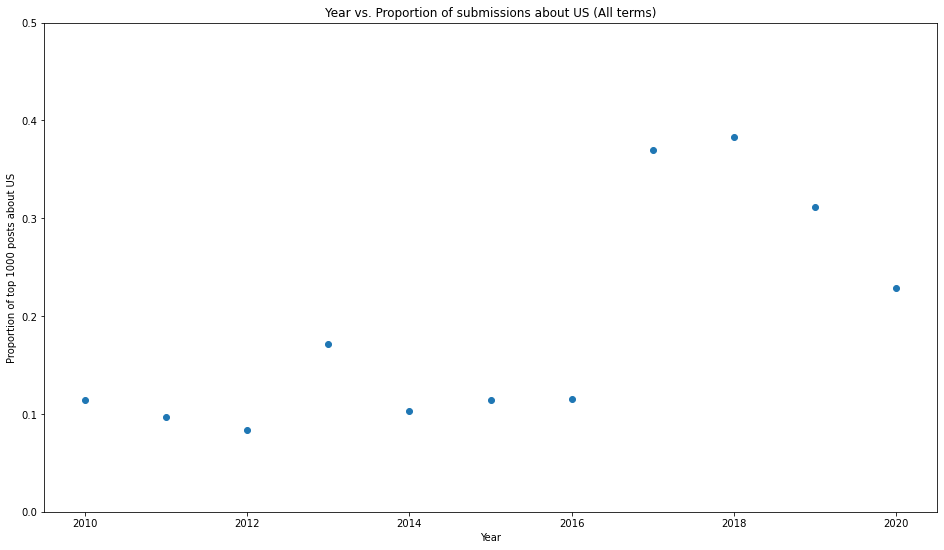

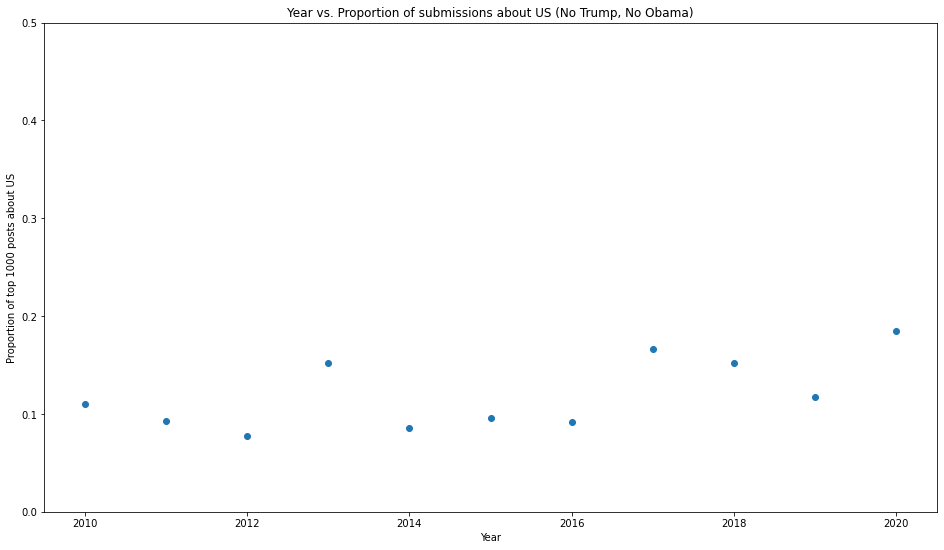

In [24]:
# Resize the graphs
plt.rcParams["figure.figsize"] = [16,9]

# Plot the proportions, terms include both Trump and Obama
x,y = zip(*prop_us)
plt.scatter(x,y)
plt.title('Year vs. Proportion of submissions about US (All terms)')
plt.xlabel('Year')
plt.ylabel('Proportion of top 1000 posts about US')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, .5))
plt.show()

# Plot the proportions, terms exclude both Trump and Obama
x,y = zip(*prop_us_no_trump)
plt.scatter(x,y)
plt.title('Year vs. Proportion of submissions about US (No Trump, No Obama)')
plt.xlabel('Year')
plt.ylabel('Proportion of top 1000 posts about US')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, .5))
plt.show()

Looking at the scatterplots above, it appears that there may be a polynomial relationship for the plot of proportions when we use all terms, however there seems to be a linear relationship when excluding 'Trump' and 'Obama'. Lets plot a linear regression line for both to see the general trends.

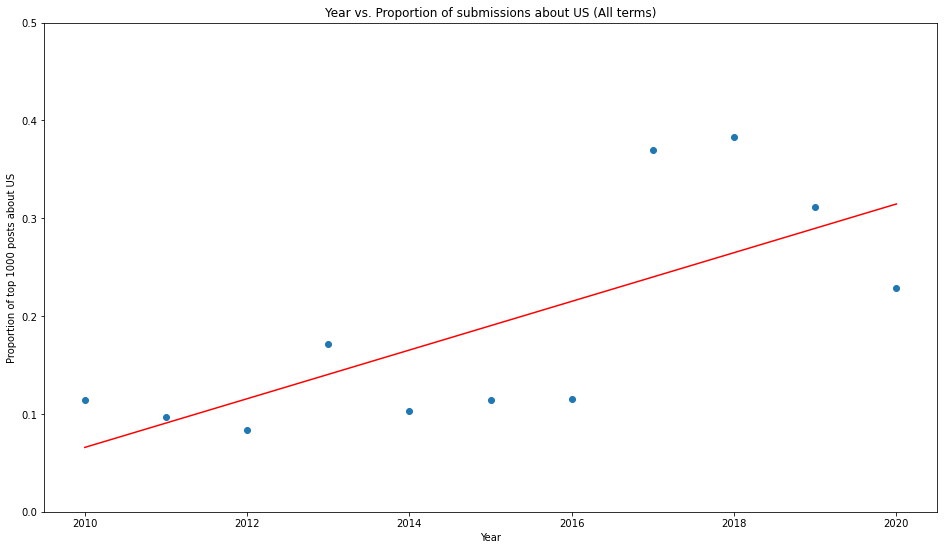

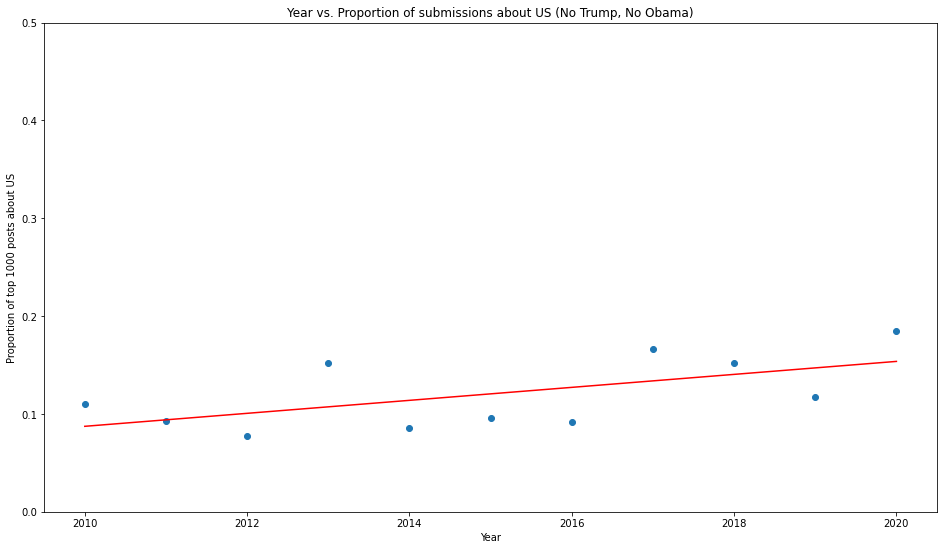

In [25]:
reg_all = LinearRegression()
reg_no_trump = LinearRegression()

# The X data will be the same, and it will just be the years. The reshape is necessary to prepare data for fitting
X = np.array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]).reshape(-1,1)

# Get the proportions to fit and then fit
y = [y[1] for y in prop_us]
reg_all.fit(X, y)

y = [y[1] for y in prop_us_no_trump]
reg_no_trump.fit(X,y)

# Plot the proportions, terms include both Trump and Obama
x,y = zip(*prop_us)
plt.scatter(x,y)
plt.title('Year vs. Proportion of submissions about US (All terms)')
plt.xlabel('Year')
plt.plot(X, reg_all.predict(X), color = 'red')
plt.ylabel('Proportion of top 1000 posts about US')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, .5))
plt.show()

# Plot the proportions, terms exclude both Trump and Obama
x,y = zip(*prop_us_no_trump)
plt.scatter(x,y)
plt.plot(X, reg_no_trump.predict(X), color = 'red')
plt.title('Year vs. Proportion of submissions about US (No Trump, No Obama)')
plt.xlabel('Year')
plt.ylabel('Proportion of top 1000 posts about US')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, .5))
plt.show()

In [ ]:
reg_no_trump.coef_

CONCLUSIONS
TRUMP MAKE GO HIGHER
OTHERWISE CONSTANT
US HAS SLOWER BEEN GETTING MORE PREVALENT, ARGUABLY MOST OF THE PREVALENCE CAN BE TIED TO TRUMP